Loaded 4776770 embeddings with 256 dimensions
Number of pairwise distances: 499,500
Distance range: 3.19 - 60.88
Mean: 17.09, Std: 4.93


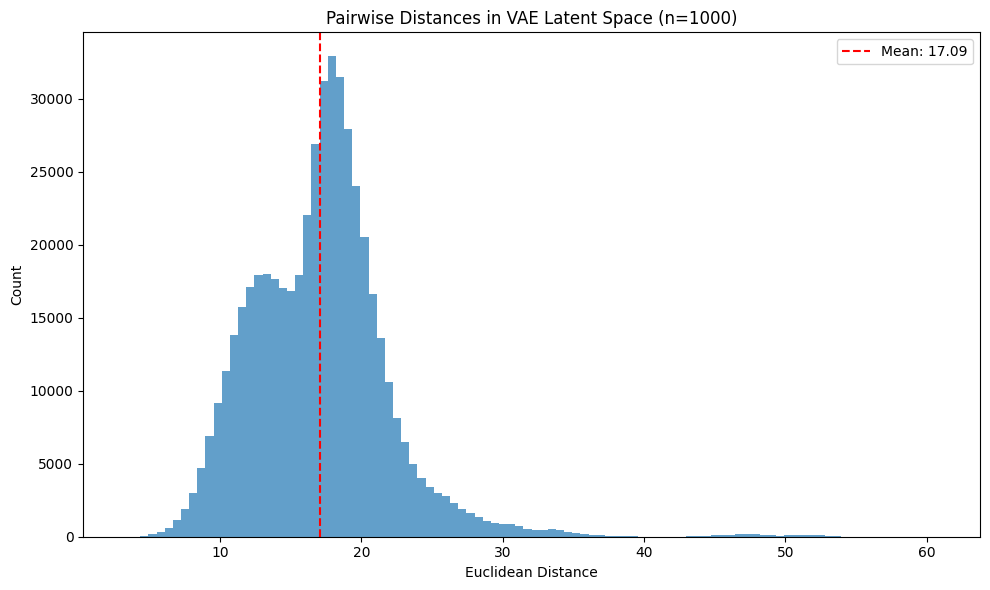

In [1]:
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Load embeddings
embeddings = np.load('Data/all_multimer_embeddings.npy')
print(f'Loaded {embeddings.shape[0]} embeddings with {embeddings.shape[1]} dimensions')

# Randomly sample 1,000 entries
rng = np.random.default_rng(42)
idx = rng.choice(len(embeddings), size = 1000, replace = False)
sample = embeddings[idx]

# Calculate pairwise Euclidean distances
distances = pdist(sample, metric = 'euclidean')
print(f'Number of pairwise distances: {len(distances):,}')
print(f'Distance range: {distances.min():.2f} - {distances.max():.2f}')
print(f'Mean: {distances.mean():.2f}, Std: {distances.std():.2f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(distances, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.axvline(distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distances in VAE Latent Space (n=1000)')
ax.legend()
plt.tight_layout()
plt.show()

Number of pairwise distances: 499,500
Distance range: 0.0477 - 1.7127
Mean: 1.0002, Std: 0.3641


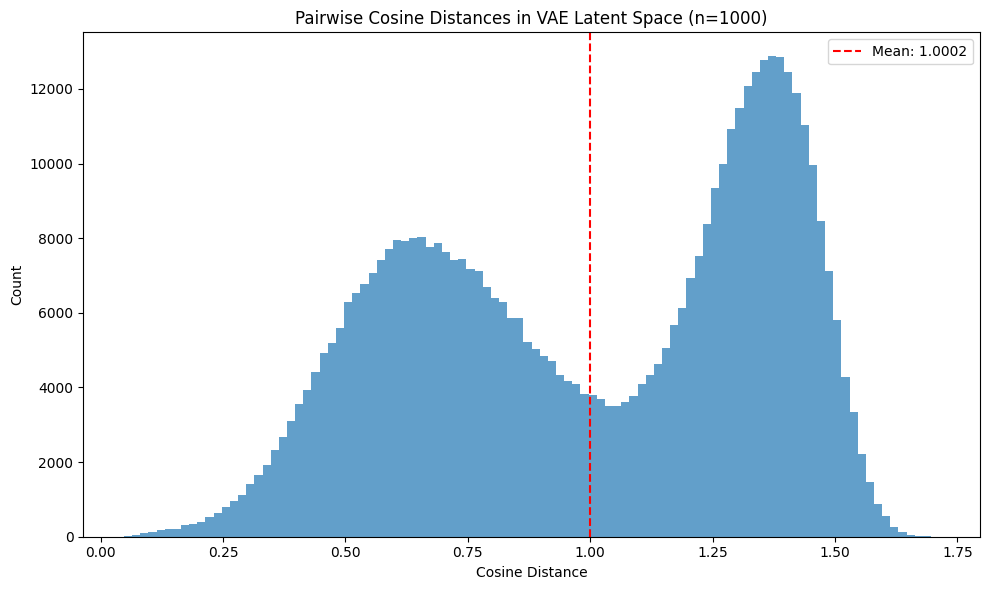

In [3]:
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Calculate pairwise cosine distances (using same sample)
cosine_distances = pdist(sample, metric = 'cosine')
print(f'Number of pairwise distances: {len(cosine_distances):,}')
print(f'Distance range: {cosine_distances.min():.4f} - {cosine_distances.max():.4f}')
print(f'Mean: {cosine_distances.mean():.4f}, Std: {cosine_distances.std():.4f}')
# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(cosine_distances, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.axvline(cosine_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {cosine_distances.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Cosine Distances in VAE Latent Space (n=1000)')
ax.legend()
plt.tight_layout()
plt.show()

Distances from first sequence to 4,776,769 others
Distance range: 0.0000 - 1.6646
Mean: 1.0103, Std: 0.3608


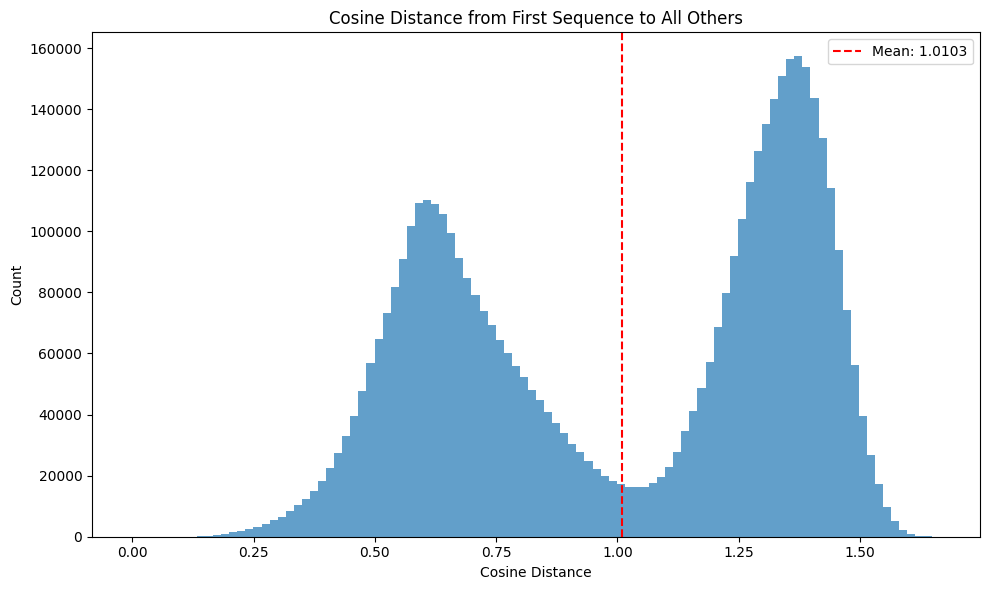

In [5]:
from scipy.spatial.distance import cdist

# Calculate cosine distance from first sequence to all others
first_seq = embeddings[1:2]  # Keep 2D shape
all_others = embeddings[1:]

distances_from_first = cdist(first_seq, all_others, metric = 'cosine').flatten()
print(f'Distances from first sequence to {len(distances_from_first):,} others')
print(f'Distance range: {distances_from_first.min():.4f} - {distances_from_first.max():.4f}')
print(f'Mean: {distances_from_first.mean():.4f}, Std: {distances_from_first.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(distances_from_first, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.axvline(distances_from_first.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances_from_first.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Cosine Distance from First Sequence to All Others')
ax.legend()
plt.tight_layout()
plt.show()

In [6]:
from scipy.spatial.distance import cdist

first_seq = embeddings[0:1]
distances = cdist(first_seq, embeddings[1:], metric = 'cosine').flatten()
closest_idx = distances.argmin() + 2  # +2 because: +1 for skipping first, +1 for 1-based
print(f'Closest to first: index {closest_idx} (distance: {distances.min():.4f})')

Closest to first: index 105937 (distance: 0.0925)


Loaded k-mer data: (4776770, 10965)
Total 7-mer frequency values: 39,131,299,840
Range: 0.000000 - 0.543727
Mean: 0.000122, Std: 0.000262


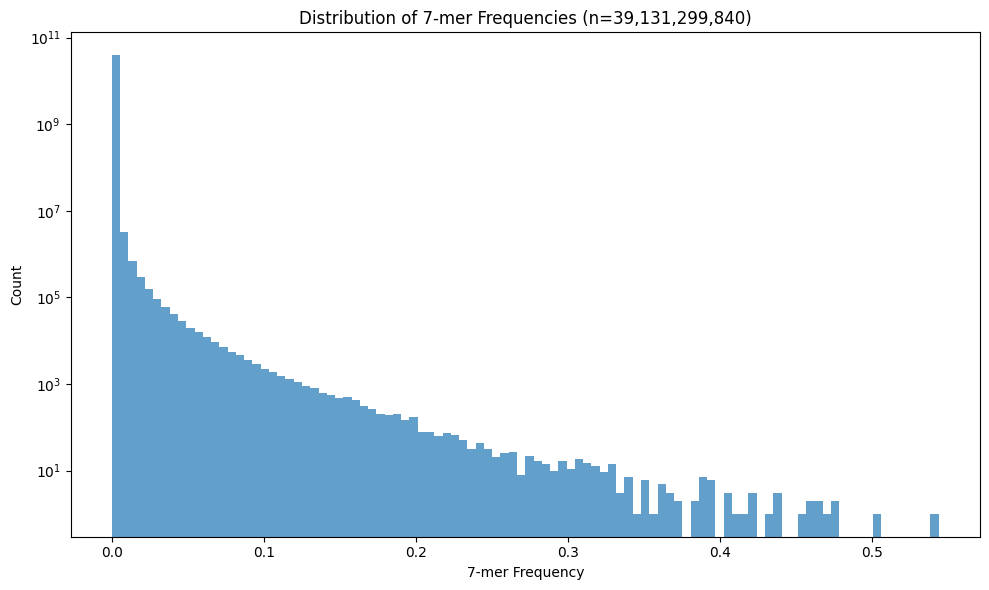

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load k-mer data
kmers = np.load('Data/all_kmers.npy')
print(f'Loaded k-mer data: {kmers.shape}')

# Extract 7-mer frequencies (columns 1 through 8192, after length column)
seven_mer_freqs = kmers[:, 1:8193].flatten()
print(f'Total 7-mer frequency values: {len(seven_mer_freqs):,}')
print(f'Range: {seven_mer_freqs.min():.6f} - {seven_mer_freqs.max():.6f}')
print(f'Mean: {seven_mer_freqs.mean():.6f}, Std: {seven_mer_freqs.std():.6f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(seven_mer_freqs, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.set_xlabel('7-mer Frequency')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of 7-mer Frequencies (n={len(seven_mer_freqs):,})')
ax.set_yscale('log')
plt.tight_layout()
plt.show()